In [36]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import GP_CommonCalculation as GP
from kernel import ARDKernel2
import torch.optim as optim
# I use torch (1.11.0) for this work. lower version may not work.
from cigp_v10 import cigp
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

2.2.1
2.2.1


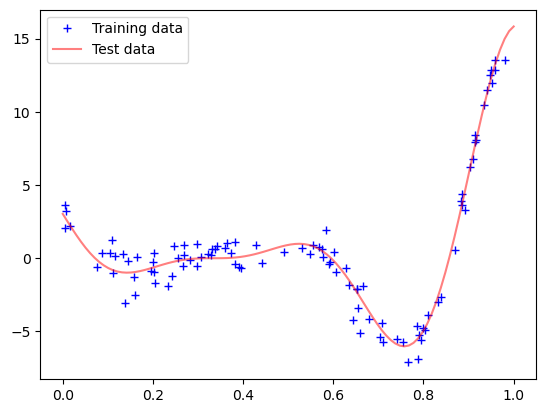

In [120]:
# generate example data
xtr, ytr,xte,yte = data.generate(100,100,seed=42,input_dim=1)
data.plot(xtr, ytr,xte,yte)

In [121]:
kernel= ARDKernel2(1)

In [122]:
#initiate_log_beta
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value.

In [123]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim=1):
        super(FeatureExtractor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, input_dim * 4),
            nn.LeakyReLU(),
            nn.Linear(input_dim * 4, input_dim * 2),
            nn.LeakyReLU(),
            nn.Linear(input_dim * 2, input_dim),
        )

    def forward(self, x):
        return self.network(x)

If you want to normalize the data, you should do it after the feature extraction.

In [124]:
feature_extractor = FeatureExtractor()

In [125]:
def negative_log_likelihood(xtr, ytr, kernel,log_beta,feature_extractor):
    x_train=feature_extractor.forward(xtr)
    Sigma = kernel(x_train, x_train) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(x_train.size(0))
    return -GP.Gaussian_log_likelihood(ytr, Sigma)

In [126]:
def forward(xtr, ytr, xte, kernel,log_beta,feature_extractor):
    x_train=feature_extractor.forward(xtr)
    x_test=feature_extractor.forward(xte)
    Sigma = kernel(x_train, x_train) + log_beta.exp().pow(-1) * torch.eye(
       x_train.size(0)) + JITTER * torch.eye(x_train.size(0))

    K_s = kernel(x_train, x_test)
    K_ss= kernel(x_test, x_test)

    mean, var = GP.conditional_Gaussian(ytr, Sigma, K_s, K_ss)

    var_diag = var.sum(dim=0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)

    return mean, var_diag

In [131]:
def train_adam(xtr, ytr, kernel, log_beta,feature_extractor, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': feature_extractor.parameters()},
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel,log_beta,feature_extractor)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in feature_extractor.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
        if i % 10 == 0:
            print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [132]:
train_adam(xtr, ytr, kernel, log_beta,feature_extractor, niteration=100,lr=0.1)

iter 0 nll:145.11215
iter 10 nll:147.92764
iter 20 nll:148.16571
iter 30 nll:147.93501
iter 40 nll:147.43953
iter 50 nll:147.00676
iter 60 nll:146.74274
iter 70 nll:146.76477
iter 80 nll:146.73967
iter 90 nll:146.73811


In [133]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel,log_beta,feature_extractor)

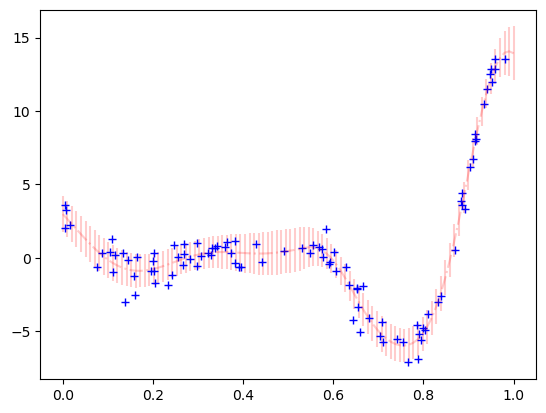

In [134]:
#xtr,ytr=data_normalizer.denormalize(xtr,ytr)
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()

# Deep Kernel GP vs Standard GP

## Objective

Demonstrate the performance improvement of Deep Kernel Gaussian Process (GP) over Standard GP when dealing with complex data.

## Instructions

1. **Modify the Data Generation Function**:
   - Change `input_dim` to 4.
   - Set the number of training data points to 400.

2. **Update the Model Parameters**:
   - Change the input dimension of the feature extractor and ARDKernel to 4.
   - Set the number of iterations to 600.

3. **Run the Code** to Compare Performance of Deep Kernel GP

In [ ]:
model2=cigp(xtr, ytr)
model2.train_adam(600,0.01)
with torch.no_grad():
    ypred2, yvar2 = model2.forward(xte)
mse_deepKernel = ((yte - ypred) ** 2).mean()
mse_standardGP = ((yte - ypred2) ** 2).mean()
print('mse_deepKernel:',mse_deepKernel)
print('mse_standardGP:',mse_standardGP)